**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
import pylab
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [4]:
# wine = pd.read_csv('monthly-australian-wine-sales.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
# wine_sales = wine_sales * 1000
# plt.figure(figsize(15,7))
# wine_sales.plot()
# plt.ylabel('Wine sales')
# pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

In [2]:
frame = pd.read_csv('Gosloto_6x45.csv', header=0, sep=';', index_col=['datetime'], parse_dates=['datetime'], dayfirst=True)
wine_sales = frame.number1

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x1440 with 0 Axes>

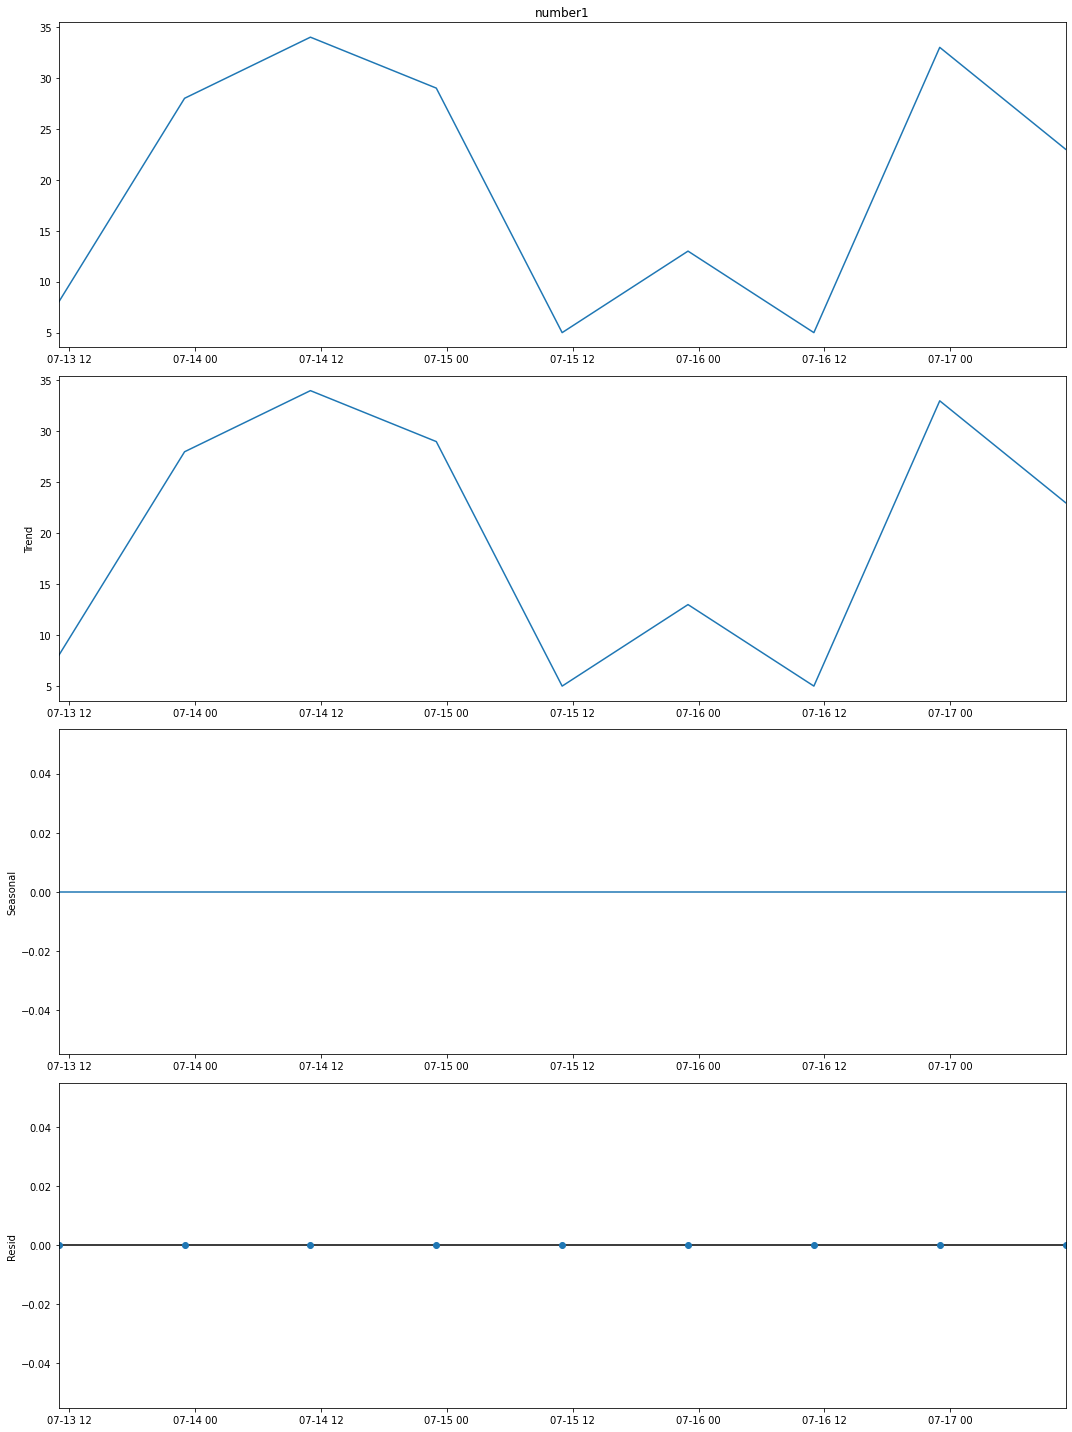

In [9]:
plt.figure(figsize(15,20))
sm.tsa.seasonal_decompose(wine_sales[5240:5249], period=1).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine_sales)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

In [43]:
wine_sales['sales_box'], lmbda = stats.boxcox(wine_sales)
plt.figure(figsize(15,7))
wine.sales_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\morestats.py:1041: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(x == x[0]):


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


<Figure size 1080x720 with 0 Axes>

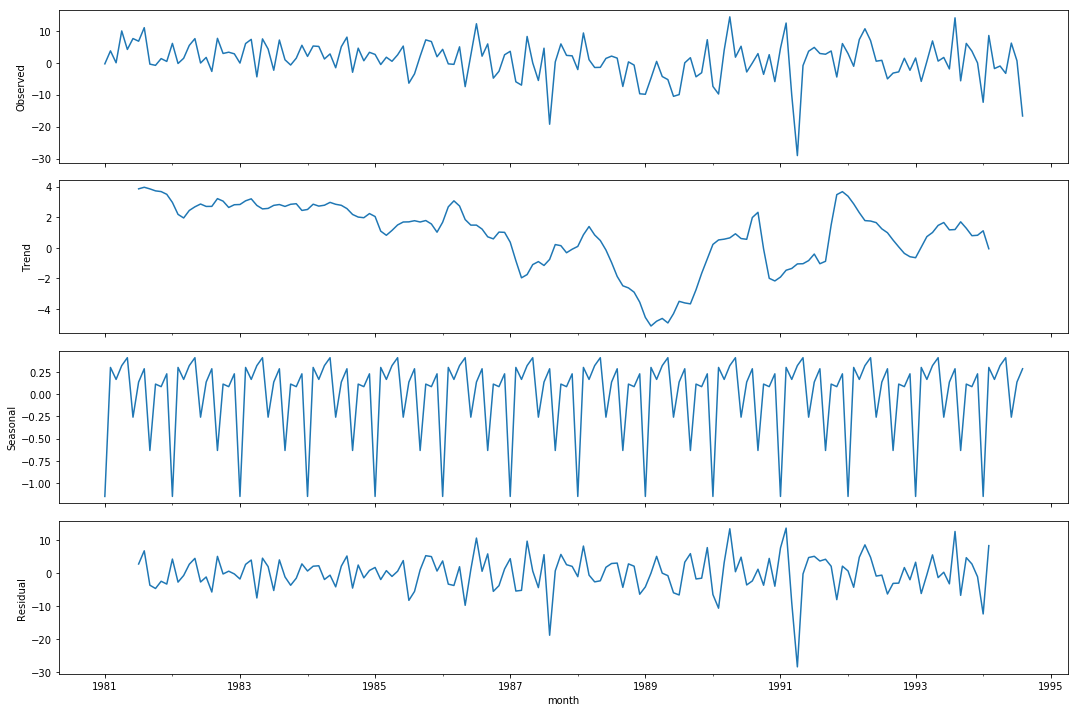

In [5]:
wine['sales_box_diff'] = wine_sales_box - wine_sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine_sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine_sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


<Figure size 1080x720 with 0 Axes>

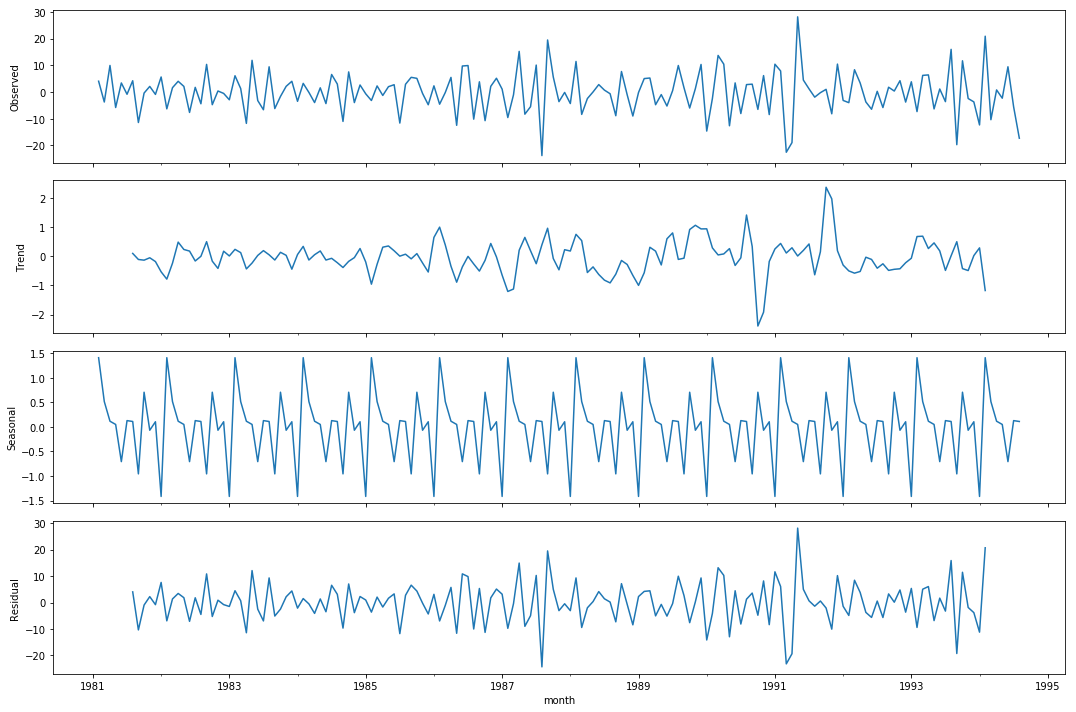

In [6]:
wine['sales_box_diff2'] = wine_sales_box_diff - wine_sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wine_sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine_sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

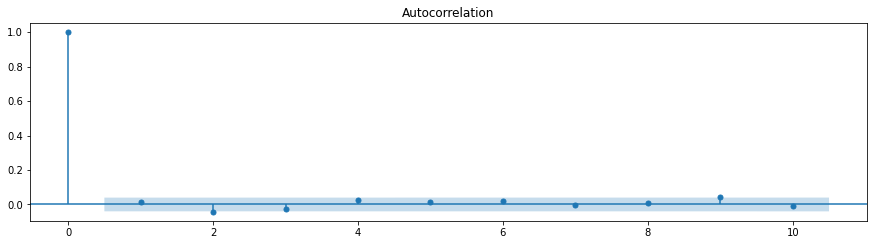

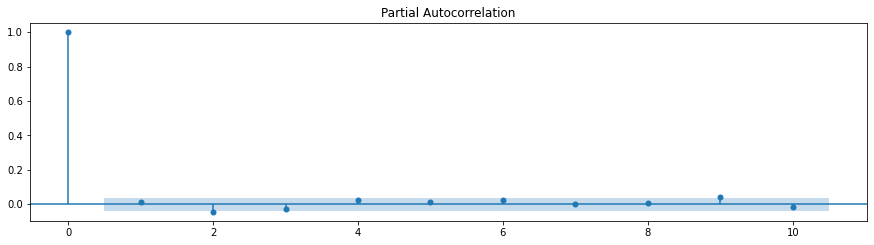

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine_sales[3000:].values.squeeze(), lags=10, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine_sales[3000:].values.squeeze(), lags=10, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [79]:
ps = range(0, 7)
d=0
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


189

In [82]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.SARIMAX(wine_sales[5000:5430], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 14min 26s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [83]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
1   (0, 0, 0, 1)  3385.784568
2   (0, 0, 0, 2)  3386.772771
4   (0, 0, 1, 1)  3386.806599
10  (0, 1, 0, 1)  3387.736316
28  (1, 0, 0, 1)  3387.769943


c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Лучшая модель:

In [84]:
print(best_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:                    number1   No. Observations:                  429
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood               -1690.892
Date:                    Thu, 26 Nov 2020   AIC                           3385.785
Time:                            21:53:13   BIC                           3393.851
Sample:                        03-15-2020   HQIC                          3388.974
                             - 10-15-2020                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9988      1.509     -0.662      0.508      -3.957       1.960
sigma2       175.9332    264.430      0.665      0.506    -342.341     694.207
Ljung-Box (L1) (Q): 

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Её остатки:

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.216631
Критерий Дики-Фуллера: p=0.000000


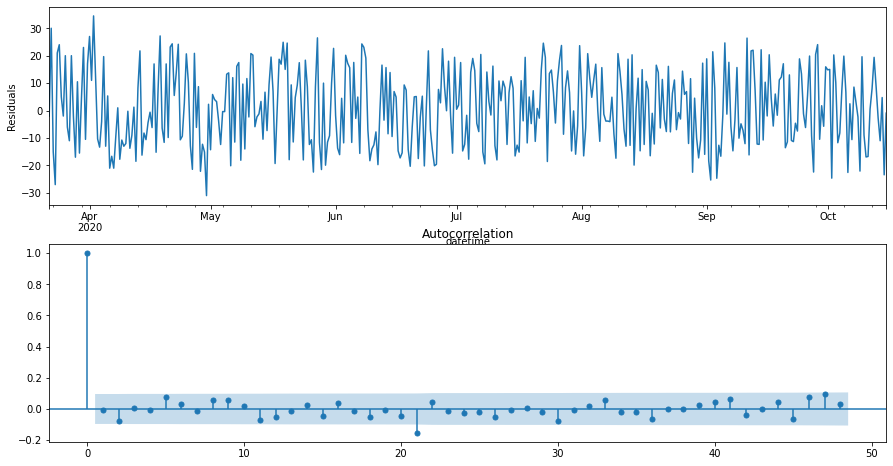

In [85]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [40]:
wine['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wine_sales.plot()
wine.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

NameError: name 'lmbda' is not defined

### Прогноз

c:\users\gryaznevdy\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='datetime'>

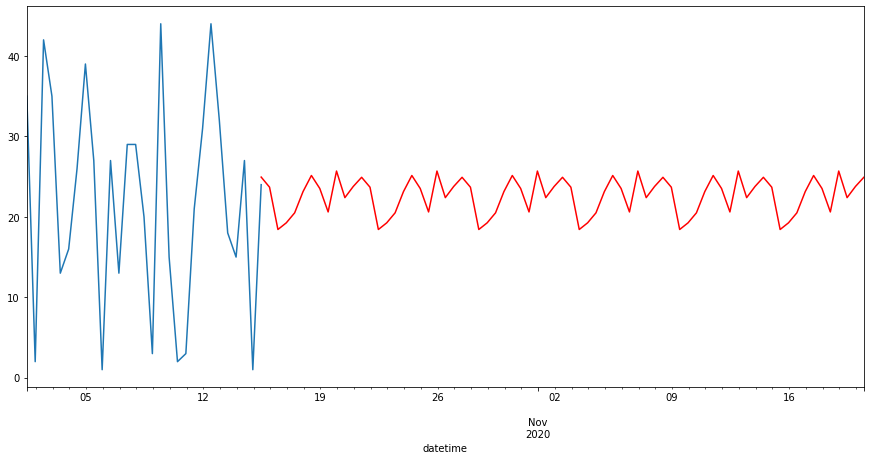

In [86]:
#wine2 = wine_sales[['sales']]
# date_list = [pd.datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
# future = pd.DataFrame(index=date_list, columns= wine2.columns)
# wine2 = pd.concat([wine2, future])
forec = pd.DataFrame()
forec['forecast'] = (best_model.predict(start=428, end=500))

plt.figure(figsize(15,7))
wine_sales[5400:].plot()
forec.forecast.plot(color='r')
# wine2.forecast.plot(color='r')
# plt.ylabel('Wine sales')
# pylab.show()